In [ ]:
## Import packages

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')
import copy

In [8]:
## Set parameters

# utility functions are a * x^0.5 + b
a_vect = [1]
b_vect = [0]

N = len(a_vect) # number of tasks

constr_A = np.array([[1]])

K = np.shape(constr_A)[0] # number of resources

C = np.array([2])

type_obj = 0 # 0 is sqrt root, 1 is log

stop_iter = 10000
delta_x = 0.01
delta_l = 0.01

x_init = np.zeros((N,))
lambda_init = np.zeros((K,))

In [9]:
## Functions of objective and constraint

def sqrt_func(a, b, x):
    return a * x**0.5 + b

def der_sqrt_func(a, x):
    if x == 0:
        return 0.5 * a / (0.0001**0.5)
    return 0.5 * a / (x**0.5)

def log_func(a, b, x):
    return log(np.dot(a, x) + 1) + b

def der_log_func(a, x):
    return a / (np.dot(a, x) + 1) + b
    
def lin_constr(A, C, x):
    return C- np.matmul(A,x)

local_objs = []
for a,b in zip(a_vect, b_vect):
    if type_obj == 0:
        local_objs.append(lambda x, a=a, b=b: sqrt_func(a,b,x))
    else:
        local_objs.append(lambda x, a=a, b=b: log_func(a,b,x))
        
local_ders = []
for a,b in zip(a_vect, b_vect):
    if type_obj == 0:
        local_ders.append(lambda x, a=a: der_sqrt_func(a,x))
    else:
        local_ders.append(lambda x, a=a: der_log_func(a,x))
    
def obj_func(x):
    s = 0
    for (x_i, f) in zip(x, local_objs):
        s += f(x_i)
    return s

def obj_func_der(x):
    out = np.zeros((N,))
    for i in range(N):
        out[i] = local_ders[i](x[i])
    return out
    
constr = (lambda x, A=constr_A, C=C: lin_constr(A, C, x))

In [10]:
x = x_init
lamb = lambda_init

x_history = []
l_history = []
obj_history = []
constr_history = []

for it in range(stop_iter):
    x_der = np.array([local_der_i(x_i) for x_i, local_der_i in zip(x,local_ders)])
    x += delta_x * (x_der - np.matmul(np.transpose(lamb), constr_A))
    x = np.maximum(np.zeros((N,)), x)
    lamb -= delta_l * (constr(x))
    lamb = np.maximum(np.zeros((K,)), lamb)
    
     # save step to memory
    x_history.append(copy.deepcopy(x))
    l_history.append(copy.deepcopy(lamb))
    obj_history.append(obj_func(x))
    constr_history.append(constr(x))

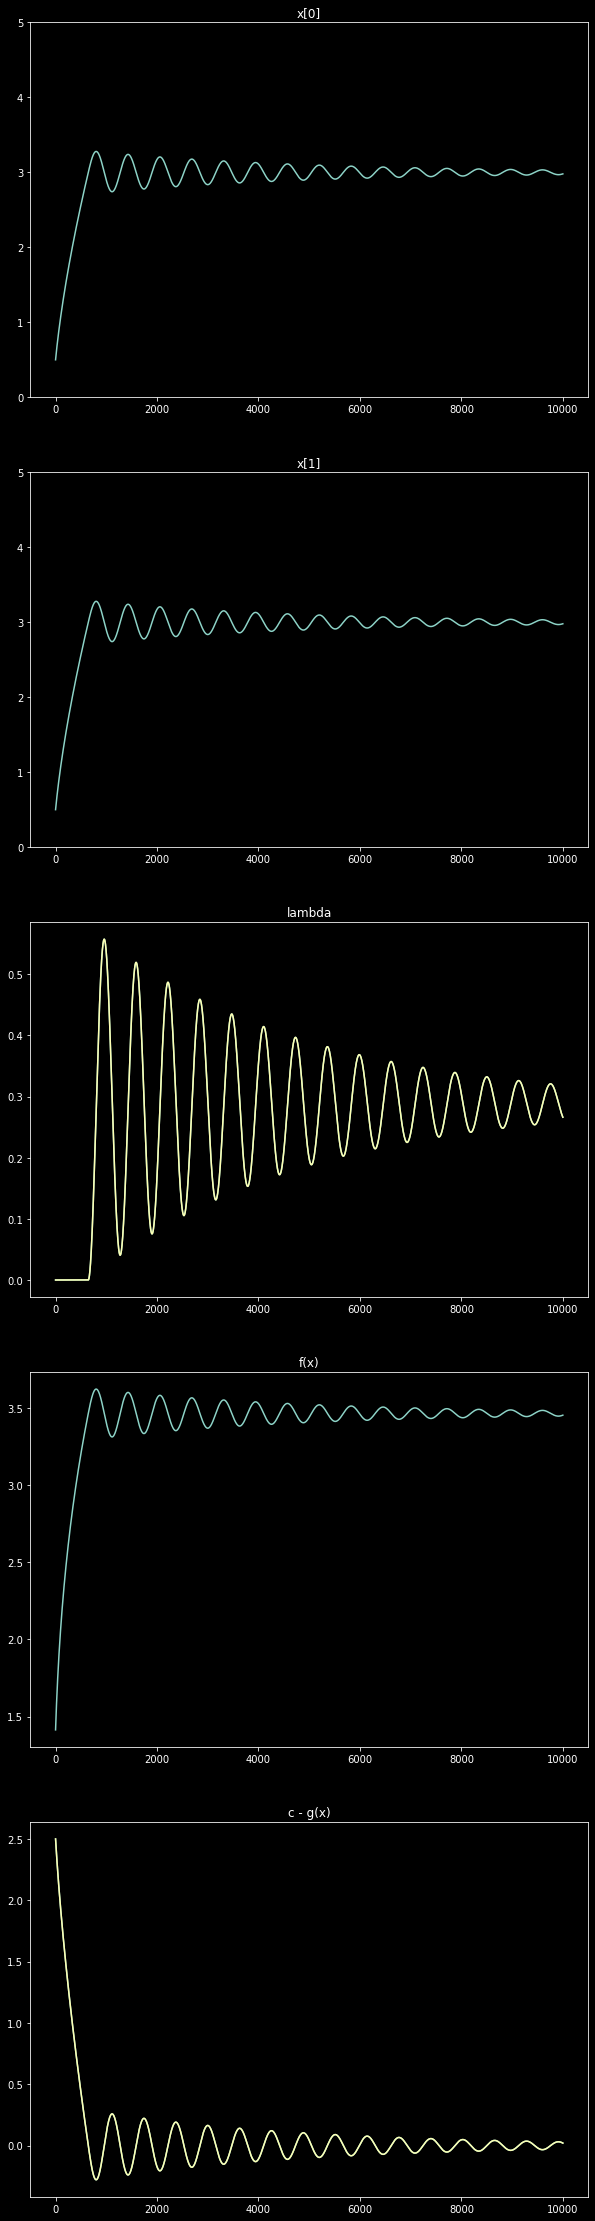

In [11]:
fig, axs = plt.subplots(N+3, 1)
for i in range(N):
    axs[i].plot([el[i] for el in x_history])
    axs[i].set_title('x[{}]'.format(i))
    axs[i].set_ylim([0,5])
axs[N].plot(l_history)
axs[N].set_title('lambda')
axs[N+1].plot(obj_history)
axs[N+1].set_title('f(x)')
axs[N+2].plot(constr_history)
axs[N+2].set_title('c - g(x)')

#for ax in axs.flat:
#    ax.set(xlabel='x-label', ylabel='y-label')

## Hide x labels and tick labels for top plots and y ticks for right plots.
    ##for ax in axs.flat:
    ##    ax.label_outer()
fig.set_figwidth(10)
fig.set_figheight(40)
plt.show()

CENTRALIZED RL

STATE is just the number of currently processed tasks. No need to include incoming tasks as we assume we can add as many as we want
ACTION is new number of processed tasks (we limit this to 100)

In [18]:
# calculate max possible x for each task
tmp_constr_A = copy.deepcopy(constr_A).astype(float)
tmp_constr_A[tmp_constr_A == 0] = 0.00001  # avoid divide by 0
max_x = np.amin(C/tmp_constr_A, axis=0).astype(int)

# make Q_table with correct dimensions
Q = np.zeros(np.concatenate((max_x+1,max_x+1,2*max_x+1))) # corresponding to local x, local m and local action 
# the 2m + 1 is because the action can also be negative (remove tasks)
# the + 1 is because 0 is also a possibility

# convert from action index to accepted-removed tasks
def a2_xchange(a):
    return a - max_x

# return new state (new number of processed tasks is deterministic while number of incoming tasks is sampled from a uniform distribution)
def state_trans(s,a):
    new_x = s[:N] + a2_xchange(a)
    new_m = np.random.uniform(np.zeros(np.shape(new_x)), max_x+1, np.shape(new_x))
    new_m = new_m.astype(int)
    return np.concatenate((new_x, new_m))

def reward(s,a):
    x = s[:N]
    x_change = a2_xchange(a)
    x_new = x + x_change
    r = 0
    for f,x_i_new in zip(local_objs, x_new):
        r += f(x_i_new)
    return r

def indexer(arr, indexes):
    out = arr
    for i in indexes:
        out = out[i]
    return out

def doable_actions(s, Q):
    out_values = []
    out_indexes = []
    x = s[:N]
    m = s[N:2*N]
    for index, value in np.ndenumerate(indexer(Q,s)):
        x_change = a2_xchange(index)
        new_x = x + x_change
        cap_constraint = (C >= np.matmul(constr_A, new_x)).all()
        positive_x = (new_x >= np.zeros(np.shape(new_x))).all()
        arrival_constraint = (m >= x_change).all()
        if cap_constraint and positive_x and arrival_constraint:
            out_values.append(value)
            out_indexes.append(index)
    return out_values, out_indexes
    
    
gamma = 0.99
epsilon_decay = 0.999
alpha = 0.01
n_episodes = 100
episode_length = 10000
Rs = []

for episode in range(n_episodes):
    tmp = np.shape(x)
    state = np.concatenate((np.random.uniform(np.zeros(tmp), max_x+1, tmp), np.random.uniform(np.zeros(tmp), max_x+1, tmp)))
    state = state.astype(int)
    rs = [] 
    epsilon = 1
    print(episode)
    for it in range(episode_length):
        out_values, out_indexes = doable_actions(state,Q)
        if np.random.uniform(0,1) > epsilon:
            tmp_ind = np.argmax(out_values)
            a = out_indexes[tmp_ind]
        else:
            random_int = int(np.random.uniform(0, len(out_indexes)))
            a = out_indexes[random_int]
        r = reward(state,a)
        rs.append(r)
        new_state = state_trans(state,a)
        Q = np.expand_dims(Q, len(np.shape(Q)))
        Q_s_a = indexer(Q, np.concatenate((state, a)))
        Q_s_a[0] = (1-alpha)*Q_s_a + alpha * (r + gamma * np.max(Q[new_state]))
        Q = np.squeeze(Q, len(np.shape(Q))-1)
        state = new_state
        epsilon *= epsilon_decay
    Rs.append(rs)



0
1
2
3
4
5


In [13]:
Q

array([[[[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
           [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
           [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
           ...,
           [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
           [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
           [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

          [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
           [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            0.00000000e+00, 0.00000

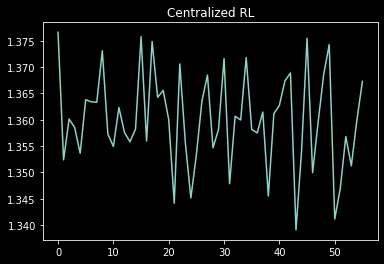

In [15]:
tot_rews = [sum(rs)/len(rs) for rs in Rs]
plt.plot(tot_rews)
plt.title('Centralized RL')
plt.show()

In [85]:
def local2joint(xs, bins):
    out = 0
    tmp = 1
    for xi, n_xi in zip(xs, bins):
        out *= n_xi
        out += xi
    return out

def joint2local(x, bins):
    out = []
    prod = np.prod(bins)
    for i in bins:
        prod = prod / i
        tmp = int(x/prod)
        out.append(tmp)
        x -= tmp * prod
    return np.array(out)

def local2joint_state(states): return local2joint

In [103]:
X = np.array([[0,0],[0,0]])
def selweird(X, indexes):
    for i in indexes:
        X = X[i]
    return X
indexes = [0,1]
X = np.expand_dims(X,2)
a = selweird(X,indexes)
a += 1
X = np.squeeze(X,2)
print(X)

[[0 1]
 [0 0]]
